In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

2025-01-17 14:04:33.510977: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-17 14:04:33.511033: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-17 14:04:33.511057: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-17 14:04:33.519127: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-17 14:04:34.479508: W tensorflow/compiler/

In [2]:
day_of_data = 20140125

In [3]:
def noise_model(x, a, alpha, b):
    return a*x**(-alpha) + b

frequency = np.linspace(1/(1440*60), 1/120, 2000).astype(np.float32)

In [4]:
file = f'./{day_of_data}/{day_of_data}_periodograms.h5'

with h5py.File(file, 'r') as f:
    periodograms = np.array(f['periodograms'][:])

In [5]:
with h5py.File(f'./{day_of_data}/{day_of_data}_data_modified.h5') as f:
    print(f.keys())
    time_series = np.array(f['time_series'][:])
    tdeltas = np.array(f['tdeltas'][:])

<KeysViewHDF5 ['tdeltas', 'time_series']>


In [6]:
model = tf.keras.models.load_model('./CNN/Confidence/ConfModel')
model.load_weights('./CNN/Confidence/ConfModelWeights.h5')
preds = model.predict(periodograms)

scaler_params = MinMaxScaler()
scaler_params.min_, scaler_params.scale_ = np.array([1.04843577, 0.07266256, 0.6477191]),np.array([0.01904265, 0.85902252, 0.06408542])
params = scaler_params.inverse_transform(preds)
params = 10**params

2025-01-17 14:05:16.073279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46661 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:81:00.0, compute capability: 8.9
2025-01-17 14:05:16.073967: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46661 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:e1:00.0, compute capability: 8.9
2025-01-17 14:05:56.398011: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17312968000 exceeds 10% of free system memory.
2025-01-17 14:06:07.780876: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17312968000 exceeds 10% of free system memory.
2025-01-17 14:06:15.181592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902


67629/67629 [==============================] - 219s 3ms/step


In [7]:
model_best_fit = tf.keras.models.load_model('./CNN/BestFit/BestFitModel')
model_best_fit.load_weights('./CNN/BestFit/BestFitWeights.h5')
preds_best_fit = model_best_fit.predict(periodograms)
scaler_params_best_fit = MinMaxScaler()
scaler_params_best_fit.min_, scaler_params_best_fit.scale_ = np.array([1.5661751,  0.19527236, 2.219622]), np.array([0.14172548, 2.0891168,  0.396035])
# np.array([1.69126585, 0.20132811, 2.21962195]), np.array([0.15304513, 2.15390391, 0.39603498])
params_best_fit = scaler_params_best_fit.inverse_transform(preds_best_fit)
params_best_fit = 10**params_best_fit

2025-01-17 14:10:48.816048: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17312968000 exceeds 10% of free system memory.
2025-01-17 14:11:00.260041: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 17312968000 exceeds 10% of free system memory.


67629/67629 [==============================] - 222s 3ms/step


In [13]:
import itertools as itools

xrange = range(2048)
yrange = range(2048)
indices_list = list(itools.product(xrange, yrange))
inside_indices_list = list(filter(lambda x: np.sqrt((x[0]-1024)**2 + (x[1]-1024)**2) <= 830, indices_list))

periodograms_3d = np.zeros(shape=(periodograms.shape[1], time_series.shape[1], time_series.shape[2]))

for index, coords in enumerate(inside_indices_list):
    periodograms_3d[:, coords[0], coords[1]] = periodograms[index]

In [17]:
params_best_fit_3d = np.zeros(shape=(params_best_fit.shape[1], time_series.shape[1], time_series.shape[2]))
params_3d = np.zeros(shape=(params.shape[1], time_series.shape[1], time_series.shape[2]))

for index, coords in enumerate(inside_indices_list):
    params_best_fit_3d[:, coords[0], coords[1]] = params_best_fit[index]
    params_3d[:, coords[0], coords[1]] = params[index]

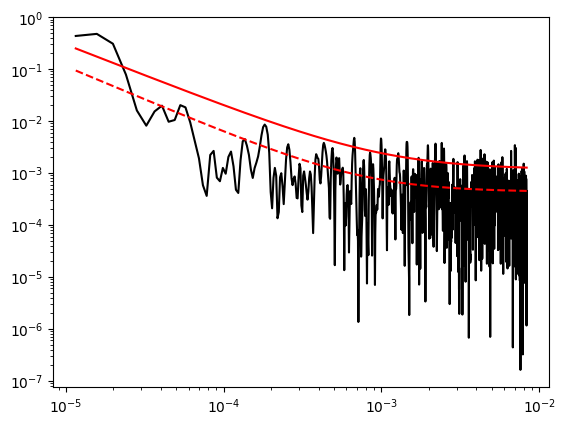

In [21]:
idx = 900
idy = 1000
plt.plot(frequency, periodograms_3d[:, idy, idx], 'k-')
plt.plot(frequency, noise_model(frequency, *params_best_fit_3d[:, idy, idx]), 'r--', label='Best Fit')
plt.plot(frequency, noise_model(frequency, *params_3d[:, idy, idx]), 'r-', label='Confidence 95%')
plt.xscale('log')
plt.yscale('log')
plt.show()